# Writing WCS info to FF fits files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS, Sip
from astropy.io import fits, ascii
from astropy.table import Table
import json

In [2]:
from astropy.time import Time
from astropy.coordinates import AltAz, EarthLocation, FK5
import astropy.units as u

In [3]:
import RMS.ConfigReader as cr

In [4]:
fbfits = fits.open("daaro/FF_NL0042_20200812_215753_000_0000512.fits")

In [5]:
t = ascii.read("daaro/fit2.txt")

In [6]:
t

No,Img X,Img Y,RA cat (deg),Dec cat (deg),Mag,-2.5*LSP,Cat X,Cat Y,RA img (deg),Dec img (deg),Err amin,Err px,Direction
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,806.518281,1693.108066,206.885,49.313333,1.86,-8.04,806.89,1693.35,206.904688,49.28633,1.79,0.45,32.5
2,856.699238,1784.671518,200.98125,54.925278,2.27,-8.34,856.71,1785.05,201.057984,54.92141,2.66,0.37,88.2
3,846.922951,1853.786386,193.507083,55.959722,1.77,-8.34,847.33,1853.56,193.481036,55.932685,1.84,0.47,-28.4
4,933.299162,2085.967763,165.932083,61.750833,1.79,-8.42,933.01,2086.32,165.889846,61.720808,2.16,0.46,129.1
5,844.250374,2113.599002,165.460417,56.3825,2.37,-7.5,843.89,2114.2,165.420744,56.379063,1.33,0.7,120.7
6,785.358114,1989.562688,178.4575,53.694722,2.44,-7.35,785.09,1990.23,178.476877,53.686907,0.83,0.72,111.7
7,1692.401324,944.904498,297.695833,8.868333,0.77,-9.17,1692.56,946.32,297.665318,8.904669,2.83,1.43,83.7
8,2023.645245,2123.344521,30.975,42.329722,2.26,-8.11,2023.98,2123.48,30.958538,42.319168,0.97,0.36,22.0
9,2126.709478,1946.879662,17.432917,35.620556,2.06,-8.24,2127.18,1946.38,17.392573,35.614408,2.0,0.68,-47.0


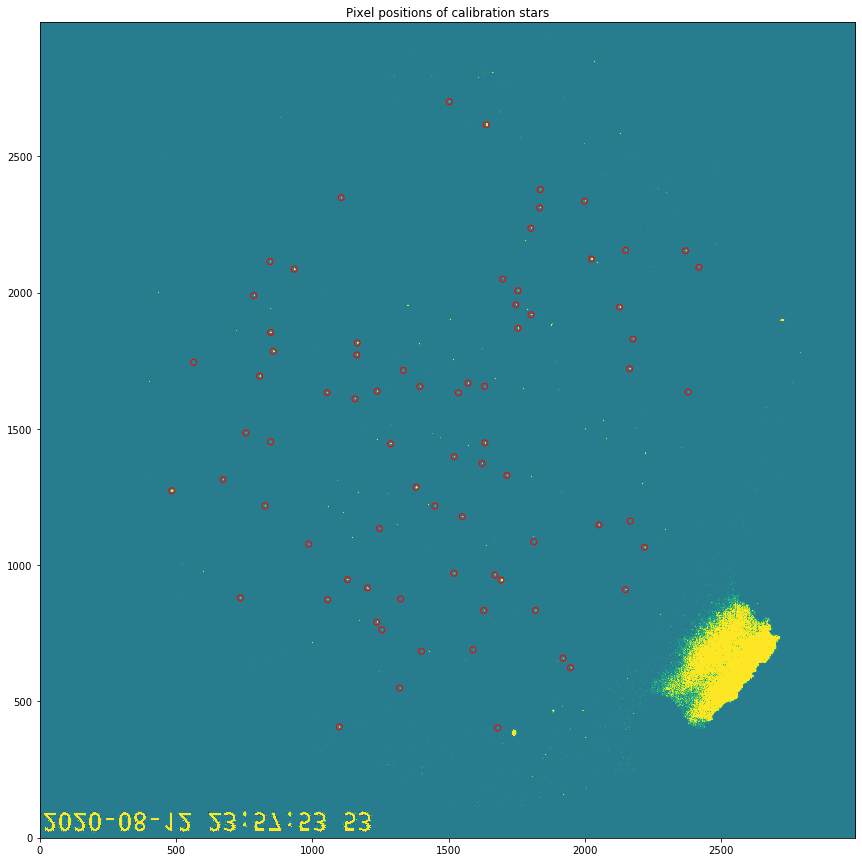

In [7]:
fig, ax0 = plt.subplots(1, 1, figsize=(15, 15))
ax0.imshow(
    fbfits[1].data,
    origin="lower",
    vmin=np.min(fbfits[1].data),
    vmax=np.quantile(fbfits[1].data, 0.99),
)
ax0.scatter(t["Img X"], t["Img Y"], marker="o", facecolors="None", color="r")
ax0.set_title("Pixel positions of calibration stars")
;

In [8]:
ymax, xmax = fbfits[1].data.shape

In [9]:
ra0 = t["RA cat (deg)"].mean()
dec0 = t["Dec cat (deg)"].mean()
x0, y0 = xmax / 2, ymax / 2
dx, dy = t["Img X"] - x0, t["Img Y"] - y0
print(ra0, dec0)

205.52288919736841 32.33381217105264


In [10]:
w = WCS(naxis=2)
w.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]
w.wcs.crval = [ra0, dec0]
w.wcs.crpix = [x0, y0]
w.wcs.cd = [[-1, 0], [0, -1]]

p = w.wcs_world2pix(t["RA cat (deg)"], t["Dec cat (deg)"], 1)

In [11]:
def solve_linear_equation(a, b):
    q, r = np.linalg.qr(a)
    y = np.dot(q.T, b)
    x = np.linalg.solve(r, y)
    return x

In [12]:
dx, dy = t["Img X"] - x0, t["Img Y"] - y0

In [13]:
order = 5

In [14]:
ixs, iys = np.meshgrid(np.arange(order + 1), np.arange(order + 1))
c = ixs + iys <= order
ix, iy = ixs[c], iys[c]

In [15]:
a = np.array([dx ** ix[i] * dy ** iy[i] for i in range(len(iy))]).T

In [16]:
p = w.wcs_world2pix(t["RA cat (deg)"], t["Dec cat (deg)"], 1)
rx, ry = p[0], p[1]

In [17]:
ax = solve_linear_equation(a, rx)
ay = solve_linear_equation(a, ry)

In [18]:
for k in range(5):
    w = WCS(naxis=2)
    w.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]
    w.wcs.cd = [[1.0, 0.0], [0.0, 1.0]]
    # w.wcs.cdelt = [-config.fov_w / xmax, -config.fov_h / ymax]
    w.wcs.crval = [ra0, dec0]
    w.wcs.crpix = [x0, y0]

    p = w.wcs_world2pix(t["RA cat (deg)"], t["Dec cat (deg)"], 1)
    rx, ry = p[0], p[1]

    ax = solve_linear_equation(a, rx)
    ay = solve_linear_equation(a, ry)

    print(ra0, dec0, ax[0], ay[0])

    ra0, dec0 = w.wcs_pix2world(([[ax[0], ay[0]]]), 1)[0]

205.52288919736841 32.33381217105264 1536.694900483424 1542.6402632691068
296.9150302809403 53.28015561410257 1496.2252407888477 1495.949137504001
297.29129742608427 53.22870038183605 1496.0004940200606 1495.9998576763353
297.2921226848762 53.22855805532143 1496.0000010916392 1495.9999996404197
297.29212450845563 53.22855769574108 1496.000000002422 1495.9999999991294


In [19]:
cd = np.array([[ax[1], ax[order + 1]], [ay[1], ay[order + 1]]])
cdinv = np.linalg.inv(cd)

In [20]:
axm = np.zeros_like(ixs).astype("float32")
aym = np.zeros_like(ixs).astype("float32")
for i in range(len(ix)):
    if ix[i] + iy[i] >= 2:
        p = np.matmul(cdinv, np.array([ax[i], ay[i]]))
        axm[iy[i], ix[i]] = p[0]
        aym[iy[i], ix[i]] = p[1]

In [21]:
w = WCS(naxis=2)
w.wcs.ctype = ["RA---ZEA-SIP", "DEC--ZEA-SIP"]
w.wcs.cd = cd
w.wcs.crval = [ra0, dec0]
w.wcs.crpix = [x0, y0]
w.sip = Sip(axm.T, aym.T, None, None, w.wcs.crpix)

In [22]:
print(np.matrix(w.sip.a))

[[ 0.00000000e+00  0.00000000e+00 -1.05298943e-06  1.77002812e-09
   8.51879331e-13 -1.02996125e-15]
 [ 0.00000000e+00 -5.17171657e-07 -2.42589408e-07  6.37582868e-13
   5.35000714e-14  0.00000000e+00]
 [ 3.90888999e-06  9.68684954e-09 -4.01541186e-13 -9.22689337e-15
   0.00000000e+00  0.00000000e+00]
 [-2.43405907e-07 -1.55189609e-12  1.13573085e-13  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.48251593e-12 -1.35242379e-14  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.59240391e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [23]:
print(
    "RMS of pixel error with poly3+radial:",
    (t["Img X"] - t["Cat X"]).std(),
    (t["Img Y"] - t["Cat Y"]).std(),
)

RMS of pixel error with poly3+radial: 0.5585024498810549 0.8453533945402663


In [24]:
print(
    "RMS of Ra/Dec error with poly3+radial:",
    (t["RA cat (deg)"] - t["RA img (deg)"]).std(),
    (t["Dec cat (deg)"] - t["Dec img (deg)"]).std(),
)

RMS of Ra/Dec error with poly3+radial: 0.05282250473275014 0.03986286763173838


In [25]:
t["WCS X"], t["WCS Y"] = w.all_world2pix(
    np.stack((t["RA cat (deg)"], t["Dec cat (deg)"]), axis=-1), 1, maxiter=200
).T

In [26]:
t["RA WCS"], t["Dec WCS"] = w.all_pix2world(
    np.stack((t["Img X"], t["Img Y"]), axis=-1), 1
).T

In [27]:
print(
    "RMS of pixel error with ZEA + SIP (order",
    order,
    "):",
    (t["Img X"] - t["WCS X"]).std(),
    (t["Img Y"] - t["WCS Y"]).std(),
)

RMS of pixel error with ZEA + SIP (order 5 ): 0.39345958664479685 0.5945868011102773


In [28]:
print(
    "RMS of Ra/Dec error with ZEA + SIP (order",
    order,
    "):",
    (t["RA cat (deg)"] - t["RA WCS"]).std(),
    (t["Dec cat (deg)"] - t["Dec WCS"]).std(),
)

RMS of Ra/Dec error with ZEA + SIP (order 5 ): 0.05961620406693384 0.032701609166120735


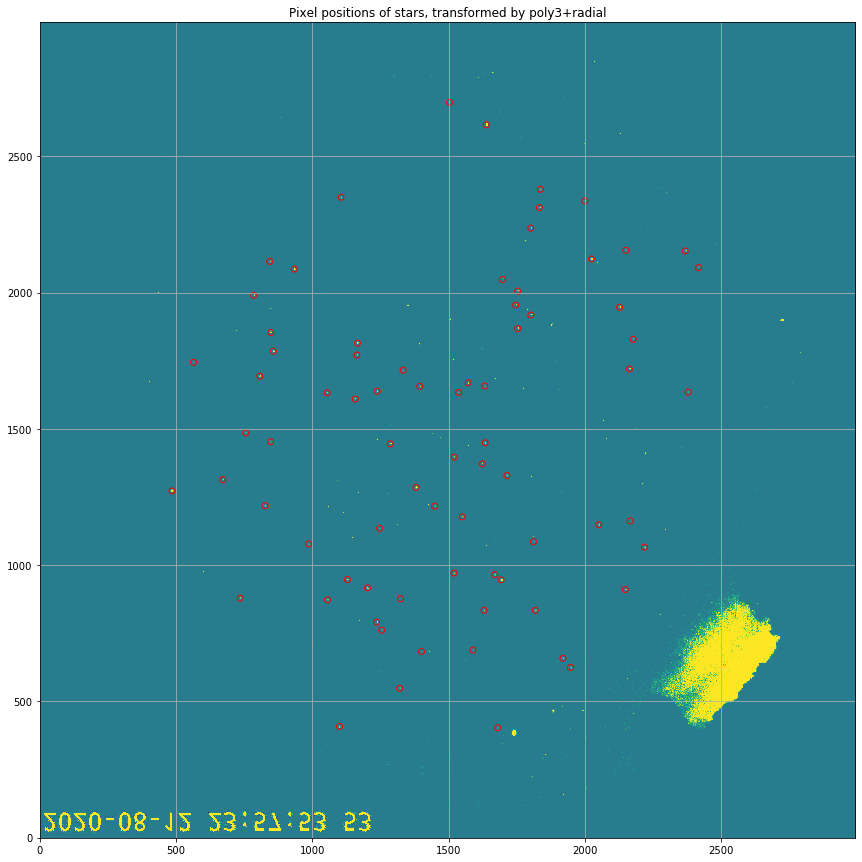

In [29]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
ax.imshow(fbfits[1].data, origin="lower", vmax=np.quantile(fbfits[1].data, 0.99))
ax.scatter(
    t["Cat X"], t["Cat Y"], marker="o", color="r", facecolors="None",
)
ax.grid()
ax.set_title("Pixel positions of stars, transformed by poly3+radial")
;

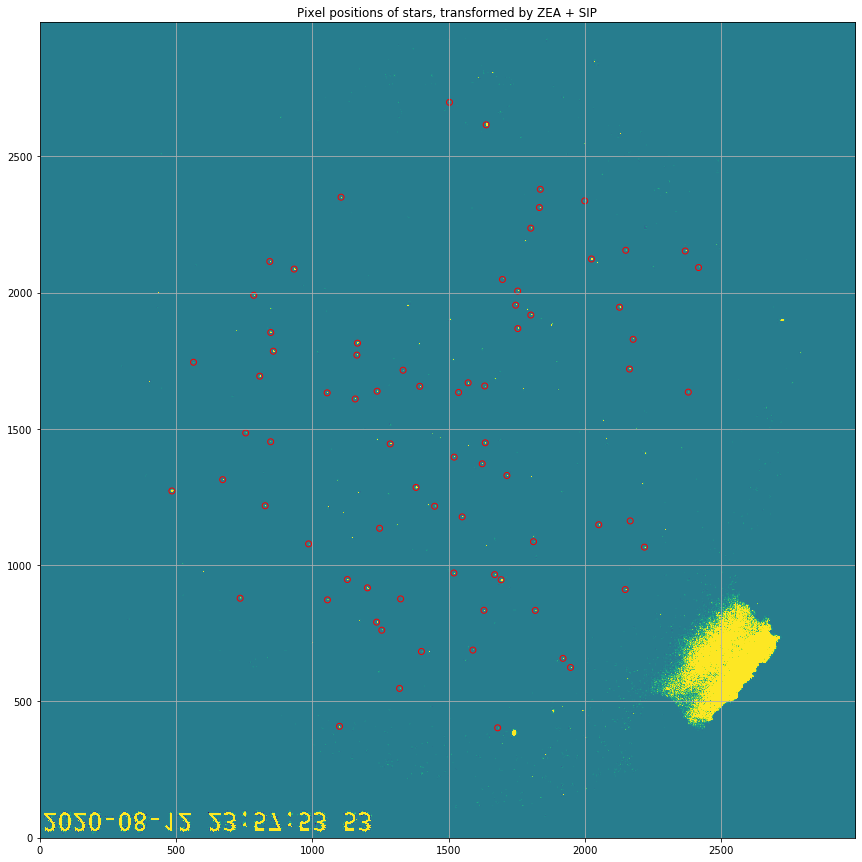

In [30]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
ax.imshow(fbfits[1].data, origin="lower", vmax=np.quantile(fbfits[1].data, 0.99))
ax.scatter(
    t["Cat X"], t["Cat Y"], marker="o", color="r", facecolors="None",
)
ax.grid()
ax.set_title("Pixel positions of stars, transformed by ZEA + SIP")
;

In [31]:
w.to_fits(relax=True)[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1496.0 / Pixel coordinate of reference point            
CRPIX2  =               1496.0 / Pixel coordinate of reference point            
PC1_1   =     0.07565118347086 / Coordinate transformation matrix element       
PC1_2   =     0.02606515743319 / Coordinate transformation matrix element       
PC2_1   =   -0.026279697809589 / Coordinate transformation matrix element       
PC2_2   =    0.075600861933166 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [32]:
wcshdr = w.to_header(relax=True)

In [33]:
w.to_header(relax=True)

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1496.0 / Pixel coordinate of reference point            
CRPIX2  =               1496.0 / Pixel coordinate of reference point            
PC1_1   =     0.07565118347086 / Coordinate transformation matrix element       
PC1_2   =     0.02606515743319 / Coordinate transformation matrix element       
PC2_1   =   -0.026279697809589 / Coordinate transformation matrix element       
PC2_2   =    0.075600861933166 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---ZEA-SIP'       / TAN (gnomonic) projection + SIP distortions    
CTYPE2  = 'DEC--ZEA-SIP'    

In [34]:
for hdrnum in range(1, 5):
    for key in wcshdr:
        fbfits[hdrnum].header.append((key, wcshdr[key]))

In [35]:
fbfits[1].writeto(
    "/Users/dijkema/Documents/perseids-aartfaac/daaro/2020-08-13T001126_WCS.fits",
    overwrite=True,
)

In [36]:
t["ZEA X"], t["ZEA Y"] = w.wcs_world2pix(
    np.stack((t["RA cat (deg)"], t["Dec cat (deg)"]), axis=-1), 1
).T

In [37]:
p = np.meshgrid(
    np.linspace(np.min(t["ZEA X"]), np.max(t["ZEA X"]), 16),
    np.linspace(np.min(t["ZEA Y"]), np.max(t["ZEA Y"]), 16),
)
x, y = p[0].ravel(), p[1].ravel()

In [38]:
xd, yd = w.sip_pix2foc(x, y, 1)

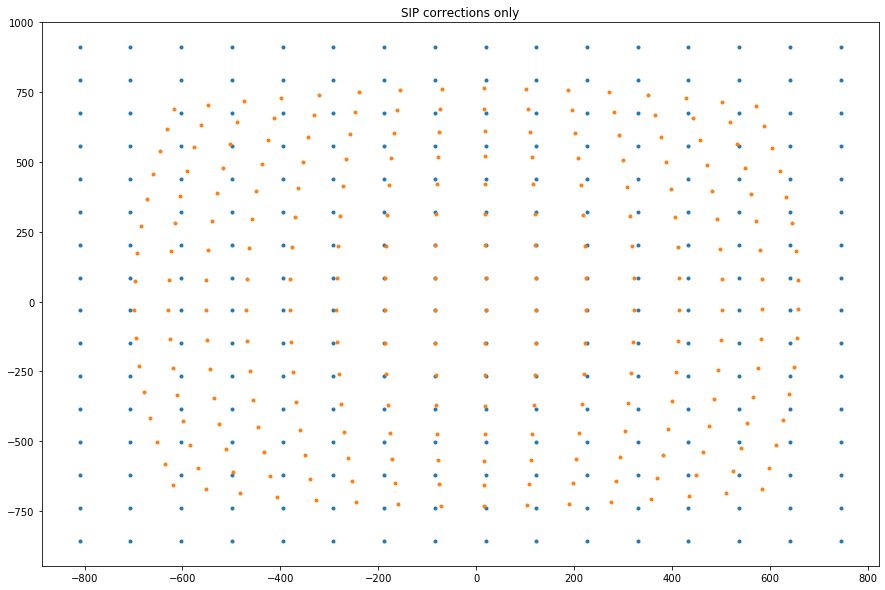

In [39]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x - x0, y - y0, ".")
ax.plot(xd, yd, ".")
ax.set_title("SIP corrections only")
;